In [1]:
import os
import pandas as pd
import talib as ta
from talib import MA_Type
import warnings
from tqdm import tqdm
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import backtesting
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import import_ipynb

warnings.simplefilter('ignore')
tqdm.pandas()

In [2]:
# period=-4800
period=-(datetime.now() - datetime(2014, 1, 1)).days
time_interval='1d'
tickers = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X']
forex_tickers = ['EURUSD', 'GBPUSD', 'USDCHF', 'USDJPY']
dir = "forex_data"

In [3]:
%run forex_data_loader.ipynb

yfinance version: 0.2.50
Start load FOREX data interval with: 1d, from: 2014-01-01 17:13:53.042350


[*********************100%***********************]  4 of 4 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2857 entries, 2014-01-01 to 2024-12-17
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (USDCHF=X, Open)       2857 non-null   float64
 1   (USDCHF=X, High)       2857 non-null   float64
 2   (USDCHF=X, Low)        2857 non-null   float64
 3   (USDCHF=X, Close)      2857 non-null   float64
 4   (USDCHF=X, Adj Close)  2857 non-null   float64
 5   (USDCHF=X, Volume)     2857 non-null   int64  
 6   (USDJPY=X, Open)       2857 non-null   float64
 7   (USDJPY=X, High)       2857 non-null   float64
 8   (USDJPY=X, Low)        2857 non-null   float64
 9   (USDJPY=X, Close)      2857 non-null   float64
 10  (USDJPY=X, Adj Close)  2857 non-null   float64
 11  (USDJPY=X, Volume)     2857 non-null   int64  
 12  (GBPUSD=X, Open)       2857 non-null   float64
 13  (GBPUSD=X, High)       2857 non-null   float64
 14  (GBPUSD=X, Low)        2857 non-null  

In [4]:
# %run file_loader.ipynb
# %run useful_functions.ipynb
# %run backtest_strategy.ipynb

from file_loader import loading_v3
from useful_functions import get_best_bb_rsi_strategy, walk_forward_optimization_by_date_range2, apply_bb_rsi_ema_strategy
from backtest_strategy import StopLossStrategy2

# log.basicConfig(level=log.INFO)

In [6]:
forex_dict = {}
# ['EURUSD', 'GBPUSD', 'USDCHF', 'USDJPY']
# symbols = ['USDCHF']
# for name in symbols:
for name in forex_tickers:
    df = pd.DataFrame()
    try:
        f = os.path.join(dir, name+'.csv')
        if os.path.isfile(f):
            df = loading_v3(f)
        df.set_index('Date', inplace=True)
    except Exception as e:
        print(f"Error loading file {name}.csv: {e}")

    try:
        print(f"Start {name} backtesting, df: {len(df)}")

        train_size_in_month = 36
        test_size_in_month = 12
        dates_range = walk_forward_optimization_by_date_range2(df.index.date[0], df.index.date[-1], train_size_in_month, test_size_in_month)
        # print(dates_range)

        params = {
            'bb_period_list': [15, 20, 30], # 13-30
            'bb_width_threshold_list': [0.002, 0.0015, 0.001],
            'atr_period_list': [13, 14, 15], # Long time frames: 20-50, Short: 2-10
            'rsi_period_list': [13, 14, 15], # Short-term intraday: 9-11, Medium-term: 14, Longer-term position: 20-30
            'ema_period_list': [28,29,30],
            'cash': 10_000,
            'maximize': 'Profit Factor',
            # 'maximize': 'Return [%]',
            # 'maximize': 'Equity Final [$]',
            # 'maximize': 'Win Rate [%]',
            # 'maximize': None, # SQN
            'max_tries': 300,
            # 'stats_item': 'Profit Factor',
            'stats_item': 'Win Rate [%]',
            # 'method': 'skopt',
            'bb_std_list': [1.5, 1.8, 2],
            'back_candle_list': [7,8,9],
        }

        signals_df = pd.DataFrame()
        for iter in tqdm(dates_range):
            train_from_date = datetime.combine(iter['train_dates'][0], datetime.min.time())
            train_end_date = datetime.combine(iter['train_dates'][1], datetime.min.time())
            test_from_date = datetime.combine(iter['test_dates'][0], datetime.min.time())
            test_end_date = datetime.combine(iter['test_dates'][1], datetime.min.time())
            
            train_set = df[(df.index >= train_from_date) & (df.index <= train_end_date)].copy()
            test_set = df[(df.index >= test_from_date) & (df.index <= test_end_date)].copy()

            train_set.reset_index(inplace=True)
            test_set.reset_index(inplace=True)

            print(f"{name} : train_set: {train_set.iloc[0].Date} - {train_set.iloc[-1].Date}, test_set: {test_set.iloc[0].Date} - {test_set.iloc[-1].Date}")

            best_params, best_performance = get_best_bb_rsi_strategy(train_set, StopLossStrategy2, params, apply_bb_rsi_ema_strategy)

            print(f"{name} : best_params: {best_params}, best_performance: {best_performance}")
            if best_performance > 0:
                combined_data = pd.concat([train_set, test_set]).reset_index(drop=True)
                combined_with_test_signal = apply_bb_rsi_ema_strategy(combined_data.copy(), best_params).copy()
                combined_with_test_signal.set_index('Date', inplace=True)

                test_with_signal = combined_with_test_signal[(combined_with_test_signal.index >= test_from_date) &
                                                             (combined_with_test_signal.index <= test_end_date)
                                                            ]
                signals_df = pd.concat([signals_df, test_with_signal], ignore_index=True)

        if not signals_df.empty:
            forex_dict[name] = signals_df
    except Exception as e:
        print(f"Error backtesting for {name}: {e}")


Start EURUSD backtesting, df: 2857


  0%|          | 0/9 [00:00<?, ?it/s]

EURUSD : train_set: 2014-01-01 00:00:00 - 2015-12-31 00:00:00, test_set: 2016-01-01 00:00:00 - 2016-12-30 00:00:00


100%|██████████| 521/521 [00:05<00:00, 103.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 114.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 79.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 115.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 112.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 112.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 112.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 116.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 116.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 86.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.51it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 83.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 81.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:09<00:00, 57.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.39it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.06it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.28it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 87.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.49it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.52it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 83.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 86.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 76.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.02it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 83.49it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.58it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.24it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [09:22<1:14:58, 562.29s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2015-01-01 00:00:00 - 2016-12-30 00:00:00, test_set: 2017-01-02 00:00:00 - 2017-12-29 00:00:00


100%|██████████| 521/521 [00:05<00:00, 99.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: -inf


100%|██████████| 521/521 [00:05<00:00, 89.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.46it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.64it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.99it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.17it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.28it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.92it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.85it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.20it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.36it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 78.56it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.53it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.91it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 87.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.02it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.35it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.34it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.70it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.84it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.73it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:08<00:00, 61.85it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.72it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 112.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 112.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.11it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 116.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

EURUSD : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 50.0


 22%|██▏       | 2/9 [18:48<1:05:50, 564.39s/it]

EURUSD : train_set: 2016-01-01 00:00:00 - 2017-12-29 00:00:00, test_set: 2018-01-01 00:00:00 - 2018-12-31 00:00:00


100%|██████████| 519/519 [00:04<00:00, 107.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 75.0, best_performance: -inf


100%|██████████| 519/519 [00:05<00:00, 102.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 106.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 107.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 106.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 109.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.80it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:07<00:00, 68.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 109.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 107.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 110.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 103.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 106.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 106.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 107.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 93.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 107.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 75.0


100%|██████████| 519/519 [00:05<00:00, 101.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.44it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.49it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 109.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.12it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 111.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 109.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 110.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 110.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 107.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 110.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 110.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 109.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.58it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 90.35it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.08it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 111.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.47it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 107.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 93.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 109.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.08it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

EURUSD : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 100.0


 33%|███▎      | 3/9 [27:59<55:50, 558.49s/it]  

EURUSD : train_set: 2017-01-02 00:00:00 - 2018-12-31 00:00:00, test_set: 2019-01-01 00:00:00 - 2019-12-31 00:00:00


100%|██████████| 519/519 [00:04<00:00, 108.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 66.66666666666666, best_performance: -inf


100%|██████████| 519/519 [00:04<00:00, 111.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 107.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 113.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 122.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 112.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 114.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 117.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 111.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 110.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 115.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.19it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 111.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 112.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 106.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 111.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 111.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 116.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 115.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 111.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 109.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 109.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: 66.66666666666666


100%|██████████| 519/519 [00:04<00:00, 116.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 106.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 113.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 112.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 110.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 109.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 112.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 117.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 91.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 85.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 82.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 90.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 87.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 106.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 106.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 115.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 114.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 109.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 106.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 89.89it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 77.97it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.20it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.59it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 88.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.29it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

EURUSD : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 100.0


 44%|████▍     | 4/9 [36:52<45:42, 548.47s/it]

EURUSD : train_set: 2018-01-01 00:00:00 - 2019-12-31 00:00:00, test_set: 2020-01-01 00:00:00 - 2020-12-31 00:00:00


100%|██████████| 521/521 [00:05<00:00, 99.69it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.03it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.64it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 116.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 116.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 116.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 114.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 79.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.50it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 114.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 83.14it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 116.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 115.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.92it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 112.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 114.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 112.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 115.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [45:32<35:53, 538.30s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2019-01-01 00:00:00 - 2020-12-31 00:00:00, test_set: 2021-01-01 00:00:00 - 2021-12-31 00:00:00


100%|██████████| 522/522 [00:04<00:00, 112.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 114.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 110.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 109.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 110.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 108.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 104.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 107.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 113.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 111.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 117.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 116.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 110.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 109.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 106.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 110.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 107.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 107.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 112.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 114.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 112.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 104.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 104.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 111.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 109.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 114.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 100.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 107.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 107.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 108.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 109.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 94.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 108.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 84.48it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 92.41it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 94.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 97.26it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 107.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 106.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 113.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 107.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 104.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 104.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 104.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 109.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 109.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 97.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 108.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 109.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 104.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 98.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 112.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 95.06it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.63it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 110.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 93.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 114.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 109.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 89.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 117.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 106.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 111.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 67%|██████▋   | 6/9 [54:02<26:25, 528.57s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2020-01-01 00:00:00 - 2021-12-31 00:00:00, test_set: 2022-01-03 00:00:00 - 2022-12-30 00:00:00


100%|██████████| 523/523 [00:05<00:00, 103.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 107.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 108.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 101.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 107.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 101.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 99.71it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 103.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 93.26it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 119.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 85.98it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 104.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 86.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 94.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 93.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 90.60it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 89.83it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 105.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 105.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 91.19it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 101.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 100.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 101.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 105.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 94.62it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 90.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 84.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 110.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 103.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 103.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 110.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 92.09it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 109.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 97.30it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 97.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 103.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 104.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 107.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 110.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 102.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 101.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 113.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 107.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 102.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 106.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 100.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 102.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 105.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 110.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 108.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 100.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 100.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 104.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 106.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 103.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 102.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 106.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 106.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 89.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 108.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 108.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 99.23it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 106.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 104.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 104.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 102.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 93.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 103.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 118.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 97.77it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 94.01it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 101.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 106.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 106.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 112.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 106.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 106.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 110.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 111.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 108.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 97.44it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 78%|███████▊  | 7/9 [1:02:56<17:40, 530.17s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2021-01-01 00:00:00 - 2022-12-30 00:00:00, test_set: 2023-01-02 00:00:00 - 2023-12-29 00:00:00


100%|██████████| 521/521 [00:05<00:00, 102.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 113.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 113.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 73.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 78.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.44it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 115.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 87.10it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.51it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.59it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 89%|████████▉ | 8/9 [1:11:46<08:50, 530.13s/it]

EURUSD : best_params: None, best_performance: -inf
EURUSD : train_set: 2022-01-03 00:00:00 - 2023-12-29 00:00:00, test_set: 2024-01-01 00:00:00 - 2024-12-17 00:00:00


100%|██████████| 520/520 [00:06<00:00, 80.32it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 66.66666666666666, best_performance: -inf


100%|██████████| 520/520 [00:05<00:00, 100.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 109.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 108.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 110.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 108.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 112.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 108.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 107.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 94.52it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 107.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 91.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.53it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 94.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 85.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.15it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 112.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.19it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.89it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 91.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 93.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:07<00:00, 68.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:07<00:00, 69.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 109.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 85.99it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 93.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 93.67it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.87it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.86it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 107.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 112.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 107.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 91.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 85.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 90.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.53it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

EURUSD : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 66.66666666666666


100%|██████████| 9/9 [1:21:07<00:00, 540.85s/it]


Start GBPUSD backtesting, df: 2857


  0%|          | 0/9 [00:00<?, ?it/s]

GBPUSD : train_set: 2014-01-01 00:00:00 - 2015-12-31 00:00:00, test_set: 2016-01-01 00:00:00 - 2016-12-30 00:00:00


100%|██████████| 520/520 [00:05<00:00, 98.66it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.73it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 93.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.76it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 94.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 94.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.60it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.45it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 94.73it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.28it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.01it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.42it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 94.77it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.95it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.67it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 94.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.22it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.00it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.18it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.54it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.09it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.90it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.36it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.27it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.05it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.57it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [09:12<1:13:37, 552.19s/it]

GBPUSD : best_params: None, best_performance: -inf
GBPUSD : train_set: 2015-01-01 00:00:00 - 2016-12-30 00:00:00, test_set: 2017-01-02 00:00:00 - 2017-12-29 00:00:00


100%|██████████| 520/520 [00:05<00:00, 98.90it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: -inf


100%|██████████| 520/520 [00:05<00:00, 97.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.75it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.11it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.42it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.20it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.82it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.10it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.21it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.76it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.48it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.05it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.11it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.22it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.43it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.32it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.75it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.83it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.84it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 91.82it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.80it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.55it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

GBPUSD : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 100.0


 22%|██▏       | 2/9 [18:23<1:04:23, 551.93s/it]

GBPUSD : train_set: 2016-01-01 00:00:00 - 2017-12-29 00:00:00, test_set: 2018-01-01 00:00:00 - 2018-12-31 00:00:00


100%|██████████| 518/518 [00:05<00:00, 101.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: -inf


100%|██████████| 518/518 [00:05<00:00, 94.76it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 101.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 97.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 96.97it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 95.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 102.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 96.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 95.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 103.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 94.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 97.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 94.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 95.82it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 99.22it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 100.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 96.95it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 97.85it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 94.43it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 99.96it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 103.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 104.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 106.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 109.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 106.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 102.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 106.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 105.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 111.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 112.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 111.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 112.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 109.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 114.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 104.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 102.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 99.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 89.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 100.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 92.48it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:07<00:00, 73.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 93.57it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 93.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 96.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 96.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 89.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 100.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 96.70it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 98.50it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 103.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 102.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 94.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 96.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 91.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 95.99it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 96.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 98.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 103.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 98.03it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 94.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 94.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 98.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 101.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 79.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 82.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 78.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:07<00:00, 72.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 90.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 85.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 87.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 74.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:07<00:00, 67.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:09<00:00, 52.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 76.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:07<00:00, 70.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:09<00:00, 54.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:08<00:00, 59.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 80.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 78.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 75.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 95.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

GBPUSD : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 100.0


 33%|███▎      | 3/9 [28:25<57:27, 574.62s/it]  

GBPUSD : train_set: 2017-01-02 00:00:00 - 2018-12-31 00:00:00, test_set: 2019-01-01 00:00:00 - 2019-12-31 00:00:00


100%|██████████| 519/519 [00:05<00:00, 92.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.59it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 90.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.81it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.26it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.62it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 85.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:11<00:00, 45.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:09<00:00, 53.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:10<00:00, 50.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:13<00:00, 38.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:12<00:00, 40.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.19it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:07<00:00, 67.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:08<00:00, 58.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:08<00:00, 59.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:08<00:00, 61.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:07<00:00, 72.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:08<00:00, 58.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:09<00:00, 54.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:10<00:00, 50.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:11<00:00, 43.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:07<00:00, 73.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 74.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:10<00:00, 50.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:09<00:00, 55.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:11<00:00, 47.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 79.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:08<00:00, 61.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:08<00:00, 64.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 82.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:12<00:00, 40.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:09<00:00, 52.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:10<00:00, 49.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:09<00:00, 57.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:09<00:00, 52.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 83.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 76.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 91.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 83.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 76.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 80.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.63it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 83.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 75.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:07<00:00, 67.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 87.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 88.89it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 79.07it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 86.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:07<00:00, 71.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.50it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 90.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 82.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 89.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 84.40it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 87.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.70it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 85.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:07<00:00, 73.84it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 93.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 81.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 84.12it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 93.93it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 85.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.23it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 89.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [40:54<53:36, 643.32s/it]

GBPUSD : best_params: None, best_performance: -inf
GBPUSD : train_set: 2018-01-01 00:00:00 - 2019-12-31 00:00:00, test_set: 2020-01-01 00:00:00 - 2020-12-31 00:00:00


100%|██████████| 521/521 [00:07<00:00, 73.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: -inf


100%|██████████| 521/521 [00:05<00:00, 93.32it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 81.50it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.77it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 81.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 73.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 78.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 87.30it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 77.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 77.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.38it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.17it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 86.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.39it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.46it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 83.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.61it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.84it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 75.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:08<00:00, 63.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 72.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.89it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.13it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.07it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 78.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 76.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 72.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.45it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.91it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 80.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 80.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 71.25it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.40it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.98it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.36it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 87.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

GBPUSD : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 50.0


 56%|█████▌    | 5/9 [51:27<42:38, 639.70s/it]

GBPUSD : train_set: 2019-01-01 00:00:00 - 2020-12-31 00:00:00, test_set: 2021-01-01 00:00:00 - 2021-12-31 00:00:00


100%|██████████| 522/522 [00:05<00:00, 101.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: -inf


100%|██████████| 522/522 [00:05<00:00, 97.83it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 94.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 82.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 88.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 85.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 91.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 87.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 91.53it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 95.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 88.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 86.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 88.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 94.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 81.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 93.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:09<00:00, 57.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 81.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 75.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:11<00:00, 44.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:14<00:00, 37.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 95.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 92.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 93.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 98.23it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 77.98it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 94.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 94.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 74.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 93.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 88.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 81.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 88.11it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 94.97it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 95.93it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 98.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 87.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 98.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 93.20it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 90.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 92.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:07<00:00, 73.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:07<00:00, 67.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:07<00:00, 74.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 85.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 86.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 96.43it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 83.57it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 95.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 89.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 79.99it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 84.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 85.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 85.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 87.88it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 89.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 85.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 76.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 79.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 93.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 89.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 84.93it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 93.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 97.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 94.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 96.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 96.67it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 98.36it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 91.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 93.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 92.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 84.94it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 90.41it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 100.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 92.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 87.14it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

GBPUSD : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 50.0


 67%|██████▋   | 6/9 [1:02:20<32:12, 644.10s/it]

GBPUSD : train_set: 2020-01-01 00:00:00 - 2021-12-31 00:00:00, test_set: 2022-01-03 00:00:00 - 2022-12-30 00:00:00


100%|██████████| 523/523 [00:05<00:00, 96.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 104.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 109.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 103.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 102.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 92.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 86.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 94.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 86.79it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 96.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 90.44it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 89.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 103.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 100.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 100.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 91.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 104.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 89.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 75.93it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 89.73it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 96.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 88.29it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 95.28it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 86.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 79.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 85.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 90.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 90.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 87.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 96.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 91.22it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 86.95it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 94.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 100.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 98.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 99.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 85.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 78.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 85.84it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 85.71it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 81.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 105.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 91.55it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 104.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 85.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 92.23it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 87.93it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 88.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 101.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 98.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 106.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 96.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 87.53it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 85.54it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 97.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 98.71it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 87.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 89.78it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 98.43it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 106.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 98.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 82.52it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 89.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 94.01it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 91.68it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 93.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 98.12it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 78.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 93.65it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 83.64it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 111.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 89.65it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 96.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 102.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 76.36it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 90.06it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 89.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 91.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 92.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 88.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 84.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 78%|███████▊  | 7/9 [1:12:14<20:55, 627.89s/it]

GBPUSD : best_params: None, best_performance: -inf
GBPUSD : train_set: 2021-01-01 00:00:00 - 2022-12-30 00:00:00, test_set: 2023-01-02 00:00:00 - 2023-12-29 00:00:00


100%|██████████| 521/521 [00:05<00:00, 88.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 66.66666666666666, best_performance: -inf


100%|██████████| 521/521 [00:05<00:00, 97.72it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 112.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.64it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 79.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 80.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.46it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.39it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 86.00it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.51it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.55it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.03it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.81it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.58it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.19it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.64it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 80.99it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 81.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.71it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.75it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 86.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.49it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.06it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.73it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.58it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.55it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.51it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 86.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

GBPUSD : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 66.66666666666666


 89%|████████▉ | 8/9 [1:21:59<10:14, 614.17s/it]

GBPUSD : train_set: 2022-01-03 00:00:00 - 2023-12-29 00:00:00, test_set: 2024-01-01 00:00:00 - 2024-12-17 00:00:00


100%|██████████| 520/520 [00:04<00:00, 104.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 75.0, best_performance: -inf


100%|██████████| 520/520 [00:04<00:00, 106.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.58it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.19it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 108.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 109.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 107.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 109.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 109.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.05it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 107.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.97it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.78it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 109.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.37it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 81.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 108.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 108.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.62it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.83it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 108.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 110.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 110.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 108.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 111.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 107.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 109.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 107.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 108.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 108.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

GBPUSD : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 75.0


100%|██████████| 9/9 [1:30:57<00:00, 606.44s/it]


Start USDCHF backtesting, df: 2857


  0%|          | 0/9 [00:00<?, ?it/s]

USDCHF : train_set: 2014-01-01 00:00:00 - 2015-12-31 00:00:00, test_set: 2016-01-01 00:00:00 - 2016-12-30 00:00:00


100%|██████████| 521/521 [00:04<00:00, 107.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: -inf


100%|██████████| 521/521 [00:04<00:00, 104.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.65it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.21it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.23it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.29it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.64it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 87.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 80.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.73it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.79it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.78it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.82it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.00it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.12it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.60it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

USDCHF : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 100.0


 11%|█         | 1/9 [09:13<1:13:49, 553.63s/it]

USDCHF : train_set: 2015-01-01 00:00:00 - 2016-12-30 00:00:00, test_set: 2017-01-02 00:00:00 - 2017-12-29 00:00:00


100%|██████████| 521/521 [00:04<00:00, 109.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.70it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 80.51it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.76it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.24it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.52it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.76it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 83.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.83it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.07it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.16it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.28it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.12it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 80.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.26it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 79.19it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 113.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.81it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.26it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.96it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 79.39it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 83.55it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 87.45it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 86.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.77it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 78.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [18:54<1:06:28, 569.80s/it]

USDCHF : best_params: None, best_performance: -inf
USDCHF : train_set: 2016-01-01 00:00:00 - 2017-12-29 00:00:00, test_set: 2018-01-01 00:00:00 - 2018-12-31 00:00:00


100%|██████████| 519/519 [00:05<00:00, 89.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: -inf


100%|██████████| 519/519 [00:05<00:00, 89.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.13it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.50it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 90.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 90.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.97it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.90it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 87.88it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 90.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 91.26it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.37it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 103.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.51it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 86.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 78.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 82.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 86.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 109.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 93.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 76.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 93.34it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 81.03it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.34it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 86.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 91.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 88.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.89it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 91.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 79.92it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.72it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.78it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 89.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 89.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.82it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 90.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 85.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 86.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.61it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 103.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.82it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 88.10it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 87.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 85.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 81.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

USDCHF : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 50.0


 33%|███▎      | 3/9 [28:49<58:06, 581.11s/it]  

USDCHF : train_set: 2017-01-02 00:00:00 - 2018-12-31 00:00:00, test_set: 2019-01-01 00:00:00 - 2019-12-31 00:00:00


100%|██████████| 519/519 [00:05<00:00, 99.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 20.0, best_performance: -inf


100%|██████████| 519/519 [00:05<00:00, 102.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 106.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 93.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.46it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.40it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.71it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.10it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.88it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 80.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 87.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 20.0


100%|██████████| 519/519 [00:05<00:00, 95.14it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 87.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.76it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.20it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.78it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.97it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 89.22it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 82.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 75.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 88.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.57it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 84.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 105.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 81.84it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.76it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 86.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 84.62it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 93.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 97.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 79.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 84.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.39it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 86.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 88.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.70it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 89.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 88.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.28it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 90.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 89.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 91.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 93.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

USDCHF : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 50.0


 44%|████▍     | 4/9 [38:42<48:48, 585.70s/it]

USDCHF : train_set: 2018-01-01 00:00:00 - 2019-12-31 00:00:00, test_set: 2020-01-01 00:00:00 - 2020-12-31 00:00:00


100%|██████████| 521/521 [00:05<00:00, 103.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 33.33333333333333, best_performance: -inf


100%|██████████| 521/521 [00:06<00:00, 79.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 77.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 87.69it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 79.50it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.81it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.78it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.62it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.84it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.97it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 76.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.12it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 80.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.45it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.28it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: 33.33333333333333


100%|██████████| 521/521 [00:05<00:00, 88.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 86.35it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.13it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.34it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.95it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.05it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.72it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.48it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.21it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 110.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.54it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.88it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.11it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 80.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 76.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.94it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 111.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 79.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

USDCHF : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 50.0


 56%|█████▌    | 5/9 [48:28<39:03, 585.90s/it]

USDCHF : train_set: 2019-01-01 00:00:00 - 2020-12-31 00:00:00, test_set: 2021-01-01 00:00:00 - 2021-12-31 00:00:00


100%|██████████| 522/522 [00:05<00:00, 94.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 107.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 97.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 98.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 108.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 111.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 107.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 83.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 95.02it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 100.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 104.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 85.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 86.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 90.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 114.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 110.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 97.60it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 87.31it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 88.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 95.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 106.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 106.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 106.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:07<00:00, 69.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:08<00:00, 63.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 95.21it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 87.71it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 87.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 82.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 97.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.72it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 95.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 90.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 100.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 86.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 88.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 74.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 94.46it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 94.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.23it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 98.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 104.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 85.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:08<00:00, 58.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:07<00:00, 69.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 77.01it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 75.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:08<00:00, 58.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:11<00:00, 47.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:11<00:00, 46.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:11<00:00, 46.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:08<00:00, 60.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:07<00:00, 67.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 67%|██████▋   | 6/9 [58:43<29:48, 596.00s/it]

USDCHF : best_params: None, best_performance: -inf
USDCHF : train_set: 2020-01-01 00:00:00 - 2021-12-31 00:00:00, test_set: 2022-01-03 00:00:00 - 2022-12-30 00:00:00


100%|██████████| 523/523 [00:08<00:00, 58.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: -inf


100%|██████████| 523/523 [00:09<00:00, 54.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:07<00:00, 68.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 99.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 87.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:08<00:00, 62.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 92.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:07<00:00, 67.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 79.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:08<00:00, 60.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:07<00:00, 74.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:07<00:00, 69.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:07<00:00, 73.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 94.34it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 103.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 93.27it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 91.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 84.87it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 94.05it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 93.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:07<00:00, 71.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 83.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 101.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 98.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 93.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 103.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 98.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 98.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 98.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 104.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:12<00:00, 42.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:11<00:00, 45.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:08<00:00, 60.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 79.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:12<00:00, 41.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:11<00:00, 47.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:11<00:00, 46.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:10<00:00, 48.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:09<00:00, 53.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:12<00:00, 43.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:09<00:00, 52.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:10<00:00, 49.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:10<00:00, 49.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:09<00:00, 54.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 77.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 91.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:07<00:00, 73.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 95.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 91.53it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 79.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 88.32it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 96.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 87.19it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 94.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 87.33it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 82.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 99.74it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 78.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 96.64it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 95.82it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 96.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 92.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 90.25it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 99.80it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 100.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 109.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 105.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 108.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 97.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 88.56it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 110.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 103.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 99.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 91.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 96.28it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 93.50it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 97.07it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 87.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:06<00:00, 86.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:04<00:00, 109.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 523/523 [00:05<00:00, 94.30it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

USDCHF : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 50.0


 78%|███████▊  | 7/9 [1:10:44<21:13, 636.79s/it]

USDCHF : train_set: 2021-01-01 00:00:00 - 2022-12-30 00:00:00, test_set: 2023-01-02 00:00:00 - 2023-12-29 00:00:00


100%|██████████| 521/521 [00:04<00:00, 106.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: -inf


100%|██████████| 521/521 [00:05<00:00, 99.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.31it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.22it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 70.38it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.83it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.68it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.09it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.65it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.80it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.56it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 69.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 87.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 75.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 76.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.04it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 87.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.36it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.90it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.67it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.38it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.65it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.62it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.56it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.19it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 70.44it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 109.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.26it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.63it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 112.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

USDCHF : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 50.0


 89%|████████▉ | 8/9 [1:20:32<10:21, 621.32s/it]

USDCHF : train_set: 2022-01-03 00:00:00 - 2023-12-29 00:00:00, test_set: 2024-01-01 00:00:00 - 2024-12-17 00:00:00


100%|██████████| 520/520 [00:05<00:00, 97.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 50.0, best_performance: -inf


100%|██████████| 520/520 [00:04<00:00, 106.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 90.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 93.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 90.50it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 88.13it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 110.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 107.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.20it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 109.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 113.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 110.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 82.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 87.07it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.25it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.15it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 88.77it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 88.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.65it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 109.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 91.06it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 94.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 91.03it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 83.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 86.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 84.09it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 83.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 81.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 87.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 93.85it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 93.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 106.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.55it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 86.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 78.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 111.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 93.54it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 81.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 91.59it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 86.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 85.45it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 78.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 89.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

USDCHF : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 50.0


100%|██████████| 9/9 [1:30:11<00:00, 601.30s/it]


Start USDJPY backtesting, df: 2857


  0%|          | 0/9 [00:00<?, ?it/s]

USDJPY : train_set: 2014-01-01 00:00:00 - 2015-12-31 00:00:00, test_set: 2016-01-01 00:00:00 - 2016-12-30 00:00:00


100%|██████████| 521/521 [00:04<00:00, 104.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 73.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 70.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 69.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 75.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.03it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.93it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 65.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 112.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.97it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.82it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.33it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.60it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 78.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 86.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 97.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 77.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 81.56it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.91it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.36it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.04it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.18it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 86.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 87.41it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 77.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 78.52it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.58it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 87.28it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.43it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 79.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 89.03it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.40it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [09:53<1:19:06, 593.37s/it]

USDJPY : best_params: None, best_performance: -inf
USDJPY : train_set: 2015-01-01 00:00:00 - 2016-12-30 00:00:00, test_set: 2017-01-02 00:00:00 - 2017-12-29 00:00:00


100%|██████████| 520/520 [00:05<00:00, 90.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 90.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 90.81it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.31it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 90.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 81.32it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 91.99it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 78.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.79it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 89.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.66it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 107.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 109.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 75.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 80.71it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 79.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 80.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 89.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.45it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.39it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 99.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 91.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 90.30it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 86.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 94.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.21it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 91.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 103.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 91.33it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 79.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 94.95it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 87.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.95it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 104.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.22it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 93.89it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.12it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 83.06it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 87.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 86.71it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 95.79it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 91.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 98.66it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 97.07it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 100.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 87.53it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 92.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.67it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 96.65it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:04<00:00, 105.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 101.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:05<00:00, 102.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [19:29<1:08:03, 583.37s/it]

USDJPY : best_params: None, best_performance: -inf
USDJPY : train_set: 2016-01-01 00:00:00 - 2017-12-29 00:00:00, test_set: 2018-01-01 00:00:00 - 2018-12-31 00:00:00


100%|██████████| 518/518 [00:04<00:00, 105.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 66.66666666666666, best_performance: -inf


100%|██████████| 518/518 [00:05<00:00, 93.33it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 85.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 101.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 94.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 104.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 85.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 97.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 100.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 97.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 95.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 85.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 98.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 91.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:07<00:00, 73.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 87.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:07<00:00, 71.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 85.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 80.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 84.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 92.13it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 96.60it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 102.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 92.04it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 101.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 104.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 103.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 96.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 96.86it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 87.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:07<00:00, 65.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 96.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 98.32it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 107.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 105.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 101.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 95.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 102.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 104.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 99.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 101.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 99.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 104.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 101.56it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 103.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 109.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 102.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 104.91it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 97.73it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 102.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 87.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 102.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 102.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 106.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 97.09it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 87.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 90.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 101.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 104.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 107.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 104.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 107.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 108.99it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 99.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 100.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 95.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 85.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 92.32it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 103.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 92.76it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 82.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 97.17it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 102.30it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:04<00:00, 103.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 98.60it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 101.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 84.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 87.77it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 90.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:06<00:00, 74.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 518/518 [00:05<00:00, 93.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

USDJPY : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 66.66666666666666


 33%|███▎      | 3/9 [29:22<58:45, 587.63s/it]  

USDJPY : train_set: 2017-01-02 00:00:00 - 2018-12-31 00:00:00, test_set: 2019-01-01 00:00:00 - 2019-12-31 00:00:00


100%|██████████| 519/519 [00:06<00:00, 78.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Performance, current: 100.0, best_performance: -inf


100%|██████████| 519/519 [00:05<00:00, 92.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 98.45it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 90.42it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 87.89it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 93.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.08it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 83.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.24it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 86.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 86.99it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.46it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 95.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 92.18it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 87.11it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 82.48it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.92it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 101.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 103.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 99.36it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.11it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 90.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 88.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.40it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 91.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 84.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:07<00:00, 73.72it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 85.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 82.57it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 79.64it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 82.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 85.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 87.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 84.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 94.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 89.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 80.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 86.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.94it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 108.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 180.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 176.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 179.19it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 191.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 191.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 204.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 203.05it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 187.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:03<00:00, 149.03it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 197.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 185.15it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 191.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:03<00:00, 146.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 187.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 102.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 124.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:03<00:00, 146.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 193.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 203.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 207.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 205.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 209.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 192.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 180.98it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 186.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:02<00:00, 189.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:06<00:00, 84.76it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:04<00:00, 104.07it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 96.91it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 93.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 90.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 519/519 [00:05<00:00, 100.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

USDJPY : best_params: {'cash': 10000, 'maximize': 'Profit Factor', 'max_tries': 300, 'method': 'grid', 'stats_item': 'Win Rate [%]', 'bb_period': 30, 'bb_width_threshold': 0.001, 'atr_period': 15, 'rsi_period': 15, 'std': 1.5, 'ema_period': 30, 'back_candles': 7}, best_performance: 100.0


 44%|████▍     | 4/9 [38:06<46:53, 562.72s/it]

USDJPY : train_set: 2018-01-01 00:00:00 - 2019-12-31 00:00:00, test_set: 2020-01-01 00:00:00 - 2020-12-31 00:00:00


100%|██████████| 521/521 [00:05<00:00, 100.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.10it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.19it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.17it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 108.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.78it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 107.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 67.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.50it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 92.64it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 90.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.08it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.93it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 80.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 88.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:10<00:00, 50.22it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 65.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 76.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 78.02it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:08<00:00, 62.35it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 73.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 95.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 99.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 82.47it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.76it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 79.74it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:07<00:00, 66.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 74.90it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.65it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 77.65it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 91.88it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.08it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.47it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.58it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.80it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 84.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.44it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 106.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.24it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 104.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 94.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.08it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.70it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.46it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 96.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 100.54it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 103.93it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.82it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 86.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:06<00:00, 85.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:08<00:00, 63.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 93.52it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 98.79it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.77it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 104.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 101.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.23it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:05<00:00, 102.29it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 521/521 [00:04<00:00, 105.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [48:12<38:32, 578.22s/it]

USDJPY : best_params: None, best_performance: -inf
USDJPY : train_set: 2019-01-01 00:00:00 - 2020-12-31 00:00:00, test_set: 2021-01-01 00:00:00 - 2021-12-31 00:00:00


100%|██████████| 522/522 [00:05<00:00, 100.53it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 100.94it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.36it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 106.01it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 100.34it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 107.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 107.37it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.04it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 96.43it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 115.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 92.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 87.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 91.41it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 97.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 110.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.69it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.84it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 100.06it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 107.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.27it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 97.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 96.35it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 95.61it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.88it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.71it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 104.89it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 104.09it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 100.85it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 92.64it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 94.45it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 74.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 92.62it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 87.68it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.14it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 100.96it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 96.21it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 89.97it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.55it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 104.66it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.92it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.37it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 105.16it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 108.59it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 86.28it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.25it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 98.27it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 100.12it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 92.74it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 96.00it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 110.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 95.63it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 88.72it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 96.45it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:07<00:00, 72.75it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 92.43it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 90.27it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:07<00:00, 72.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 78.51it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 85.01it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 93.00it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.69it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 97.33it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.49it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 92.44it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 106.83it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.13it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.90it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 100.73it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 103.79it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 97.78it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 101.32it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 102.86it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 99.74it/s] 


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 88.31it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 84.81it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:05<00:00, 89.48it/s]


Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [57:30<46:00, 690.08s/it]


KeyboardInterrupt: 

In [37]:
forex_dict['GBPUSD'].describe()

KeyError: 'GBPUSD'

In [34]:
sum([forex_dict[key]['Signal'].value_counts() for key in forex_dict], start=0)

Signal
0    771
Name: count, dtype: int64

In [36]:
for df in forex_dict.values():
    print(len(df[df.Signal != 0]))

0


In [ ]:
plot_candlestick_with_signals(forex_dict['EURUSD'], start_index=3300, num_rows=100)

In [25]:
results = dict()

for name, df in forex_dict.items():
    bt = Backtest(df, StopLossStrategy, cash=10000, margin=1/10, commission=0.002)
    results[name] = bt.run()

In [26]:
for name, stats in results.items():
    print("=== Stats of {} ===".format(name))
    print(stats)

=== Stats of EURUSD ===
Start                     2011-10-11 00:00:00
End                       2024-11-29 00:00:00
Duration                   4798 days 00:00:00
Exposure Time [%]                   10.338785
Equity Final [$]                  8457.876582
Equity Peak [$]                  10085.087078
Return [%]                         -15.421234
Buy & Hold Return [%]              -22.533006
Return (Ann.) [%]                   -1.225106
Volatility (Ann.) [%]                2.109607
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -16.134818
Avg. Drawdown [%]                   -5.671567
Max. Drawdown Duration     4599 days 00:00:00
Avg. Drawdown Duration     1551 days 00:00:00
# Trades                                   31
Win Rate [%]                         45.16129
Best Trade [%]                       2.057982
Worst Trade [%]                     -3.615092
Avg. Trade

In [27]:
for name, stats in results.items():
    print("=== Return of {}, {} ===".format(name, stats["Return [%]"]))


=== Return of EURUSD, -15.42123417675717 ===
=== Return of GBPUSD, -1.8521368973039354 ===
=== Return of USDCHF, -10.756902657495667 ===
=== Return of USDJPY, -9.995478405761624 ===


In [30]:
for name, stats in results.items():
    print("=== Win Rate of {}, {} ===".format(name, stats["Win Rate [%]"]))

=== Win Rate of EURUSD, 45.16129032258064 ===
=== Win Rate of GBPUSD, 62.22222222222222 ===
=== Win Rate of USDCHF, 50.0 ===
=== Win Rate of USDJPY, 32.6530612244898 ===


In [28]:
equity_curves = [stats['_equity_curve']['Equity'] for stats in results.values()]
max_length = max(len(equity) for equity in equity_curves)

# Pad each equity curve with the last value to match the maximum length
padded_equity_curves = []
for equity in equity_curves:
    last_value = equity.iloc[-1]
    padding = [last_value] * (max_length - len(equity))
    padded_equity = equity.tolist() + padding
    padded_equity_curves.append(padded_equity)

equity_df = pd.DataFrame(padded_equity_curves).T

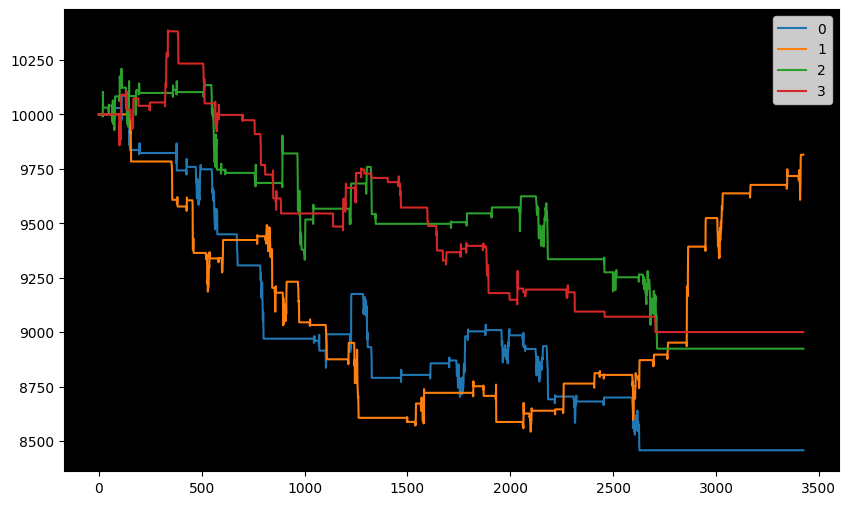

In [29]:
import matplotlib.pyplot as plt

equity_df.plot(kind='line', figsize=(10, 6), legend=True).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('black')